## Dataset

[Casting Defect Dataset](https://www.kaggle.com/code/mitanshuchakrawarty/casting-defect-detection)


The original washers dataset comprises a total of 7348 image data points, each of which is a grayscale image with dimensions of 300 by 300 pixels. Within this dataset, there are two distinct classes of images: "ok_front" and "def_front" impeller washers.

The "ok_front" class consists of 519 images, representing instances of impeller washers that are considered acceptable or in a satisfactory condition.

The "def_front" class,includes 781 images, depicting impeller washers with some form of defect or anomaly.

The dataset is further divided into train and test. The train data will be used for training and the test, for testing for Image Classification. By using this dataset, we will develop an algorithm to develop and evaluate algorithm capable of distinguishing between acceptable and defective impeller washers based on their visual features.

Note, we will downsize the Dataset so as to be able to do the training on the free RAM provided on Google Collab.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
import imghdr
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib
matplotlib.use('Agg')




#### RAM Limitations

Note : The original Data contained 7300 + Images but we had to reduce this data to about 1010 Images per class(2020 Images in total for training) because of RAM Limitations. The free RAM goes upto 12GB. For Future, Grad School, we will need to pay for more space(from usd 10).

In [ ]:
# load train and test data

train_path = '/content/drive/MyDrive/MLClassData/Manufacturing Data/train'
test_path = '/content/drive/MyDrive/MLClassData/Manufacturing Data/test'

In [ ]:
from collections import Counter

def count_images_per_class(data_dir):
    class_counts = Counter()

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images

    return class_counts

train_class_counts = count_images_per_class(train_path)
test_class_counts = count_images_per_class(test_path)

# Display the counts for the training set
print("Training Set Class Counts:")
for class_name, count in train_class_counts.items():
    print(f"{class_name} - {count} images")

# Display the counts for the test set
print("\nTest Set Class Counts:")
for class_name, count in test_class_counts.items():
    print(f"{class_name} - {count} images")


Training Set Class Counts:
def_front - 1010 images
ok_front - 1010 images

Test Set Class Counts:
def_front - 255 images
ok_front - 255 images


## Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import imghdr
import numpy as np

def preprocess_images(data_dir, image_exts=['jpeg'], image_size=(224, 224)):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    class_mapping = {}

    for class_index, image_class in enumerate(os.listdir(data_dir)):
        class_mapping[class_index] = image_class

        for image_name in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image_name)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)

                if tip not in image_exts:
                    os.remove(image_path)
                else:
                    img = cv2.resize(img, image_size)
                    cv2.imwrite(image_path, img)

                    images.append(img)
                    labels.append(class_index)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

    images = np.array(images)
    labels = np.array(labels)

    # Perform label encoding
    labels_encoded = label_encoder.fit_transform(labels)

    return images, labels_encoded, class_mapping




In [ ]:
# Preprocess training data
X_train, y_train, class_mapping_train = preprocess_images(train_path)

# Preprocess test data
X_test, y_test, class_mapping_test = preprocess_images(test_path)

print("Training Class Mapping:", class_mapping_train)
print("Test Class Mapping:", class_mapping_test)

Training Class Mapping: {0: 'def_front', 1: 'ok_front'}
Test Class Mapping: {0: 'def_front', 1: 'ok_front'}


In [ ]:
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (2020, 224, 224, 3)
Shape of y_train : (2020,)


In [ ]:
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_test : (510, 224, 224, 3)
Shape of y_test : (510,)


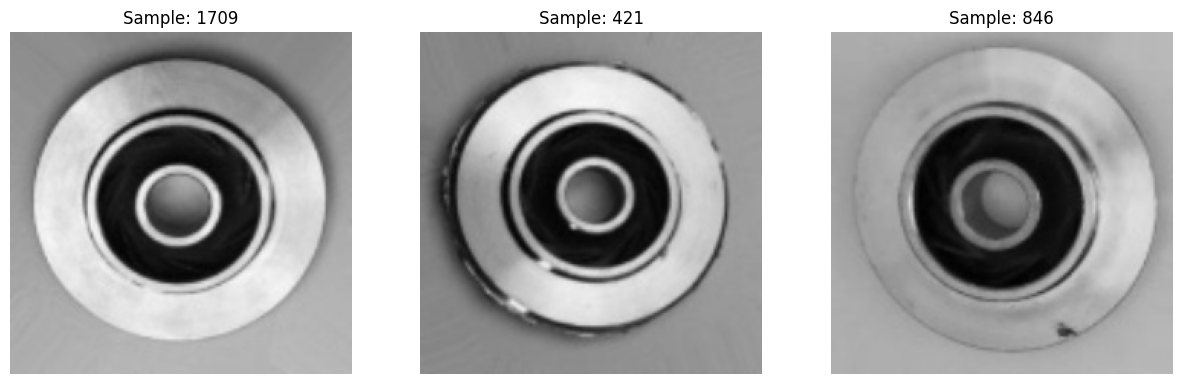

In [ ]:
# Display some random images
import matplotlib.pyplot as plt
import numpy as np

def display_images(images, num_images=3):
    num_samples, _, _, _ = images.shape
    selected_indices = np.random.choice(num_samples, num_images, replace=False)

    plt.figure(figsize=(15, 5 * num_images))

    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index])
        plt.title(f"Sample: {index}")
        plt.axis("off")

    plt.show()

# Display some random images from X_train
display_images(X_train, num_images=3)


## Data Augmentation

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0


In [ ]:
# Generate Data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
       vertical_flip=True,
       rescale=1.0) # Data had already been normalized.
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
       rescale=1.0)

batch_size = 16

# Create a generator for training data
train_data = train_datagen.flow(X_train, batch_size=batch_size, shuffle=False)

# Create a generator for test data
test_data = test_datagen.flow(X_test, batch_size=batch_size, shuffle=False)


for i in range(len(X_train) // batch_size + 1):
    batch = train_data[i]
    X_train[i * batch_size: (i + 1) * batch_size] = batch

# Iterate through the test data in batches and normalize pixel values
for i in range(len(X_test) // batch_size + 1):
    batch = test_data[i]
    X_test[i * batch_size: (i + 1) * batch_size] = batch





## Extract Features using ResNet50

Why ResNet50?

ResNet-50 has demonstrated strong performance on image classification tasks. It has achieved state-of-the-art results on benchmarks like ImageNet, showcasing its ability to learn hierarchical features and representations.

It introduces the concept of residual connections, which help address the vanishing gradient problem. Residual connections allow the model to learn identity mappings, making it easier to train very deep networks.

RAM Usage : max used -> 11.45/12.68 GB

In [ ]:
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False



58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Pass in the X_train and get the resulting features

x_feature_extractor = vgg_model.predict(X_train)
features = x_feature_extractor.reshape(x_feature_extractor.shape[0], -1)

X_train_features = features


64/64 [==============================] - 19s 120ms/step


In [ ]:
X_train_features.shape

(2020, 25088)

In [ ]:
# Do the same to X_test

X_test_features = vgg_model.predict(X_test)


16/16 [==============================] - 5s 313ms/step


In [ ]:
n_samples, width, height, n_features = X_test_features.shape
X_test_features = X_test_features.reshape((n_samples, width * height * n_features))

In [ ]:
X_test_features.shape

(510, 25088)

In [ ]:
y_test.shape

(510,)

## Use a classical ML Algorithm

#### Support Vector Machines

SVMs are particularly good at solving binary classification problems, which require classifying the elements of a data set into two groups.

To do this, SVMs use a kernel function. Instead of explicitly calculating the coordinates of the transformed space, the kernel function enables the SVM to implicitly compute the dot products between the transformed feature vectors and avoid handling expensive, unnecessary computations for extreme cases(techtarget, n.d).

In [ ]:
# Create an SVC model
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', C=1, random_state=42)

# Fit the model to the training data
svc_model.fit(X_train_features, y_train)

y_predsvc = svc_model.predict(X_test_features)


#### RandomForest Classifier

In [ ]:
# Create a RandomForestClassifier model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_features, y_train)

y_predr = rf_model.predict(X_test_features)



## Performance Evaluation

Based on the results below, Support Vector Classifier performs better than the Random Forest Classifier. We tried to optimize the performance of RF, and ended up with similar performance, hence chose to go with Support Vector Machines.

Due to the limited data, we anticipate our model to overfit to some extent. To alleviate this, more data will be needed. However, in our case, using more data was not possible due to RAM limitation.

In [ ]:
# SVC  Accuracy Score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_predsvc)
print(f'SVC Accuracy: {accuracy}')

SVC Accuracy: 0.9901960784313726


In [ ]:
# RF  Accuracy Score
accuracy = accuracy_score(y_test, y_predr)
print(f'rf Accuracy: {accuracy}')

rf Accuracy: 0.9725490196078431


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
svc_report = classification_report(y_test, y_predsvc, target_names=['def_front', 'ok_front'], digits=5)
rf_report = classification_report(y_test, y_predr, target_names=['def_front', 'ok_front'], digits=5)

print('Support Vector Classifier Report \n')
print(svc_report)

print('Random Forest Classifier Report \n')
print(rf_report)



Support Vector Classifier Report 

              precision    recall  f1-score   support

   def_front    0.99603   0.98431   0.99014       255
    ok_front    0.98450   0.99608   0.99025       255

    accuracy                        0.99020       510
   macro avg    0.99026   0.99020   0.99020       510
weighted avg    0.99026   0.99020   0.99020       510

Random Forest Classifier Report 

              precision    recall  f1-score   support

   def_front    0.96169   0.98431   0.97287       255
    ok_front    0.98394   0.96078   0.97222       255

    accuracy                        0.97255       510
   macro avg    0.97281   0.97255   0.97255       510
weighted avg    0.97281   0.97255   0.97255       510



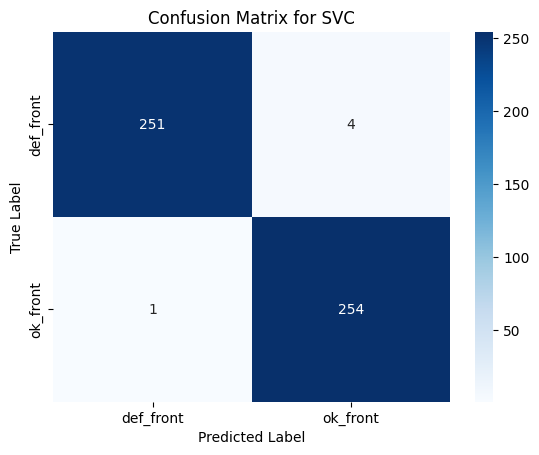

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predsvc)
class_names = ['def_front', 'ok_front']

# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for SVC")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


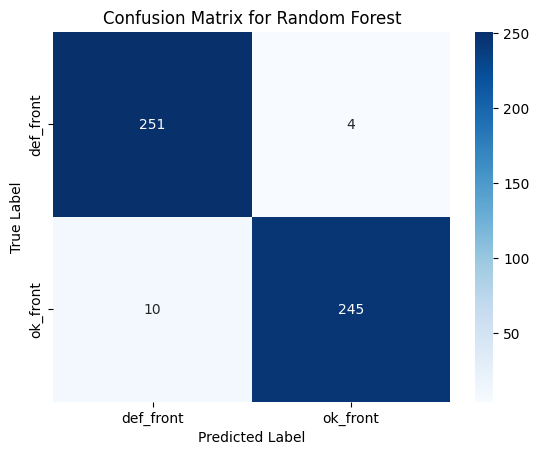

In [ ]:
# # Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_predr)
class_names = ['def_front', 'ok_front']

# Plot heatmap of confusion matrix
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### Algorithms Optimization

Gridsearch is a widely used method for hyperparameter optimization in machine learning due to its systematic and efficient exploration of hyperparameter combinations.
It employs cross-validation during the search, providing a robust evaluation of model performance across multiple subsets of the training data. The final model obtained from GridSearch is trained using the best hyperparameter values.

In [ ]:
# Hyperparameter tuning with GridSearchCV for RF
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [40, 50, 60],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_modelo = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_modelo, param_grid, cv=5)
grid_search.fit(X_train_features, y_train)

best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_features)

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Optimized Random Forest Classifier Accuracy: {accuracy_rf}')
print(f'RF Best hyperparameters: {grid_search.best_params_}')


Optimized Random Forest Classifier Accuracy: 0.9882352941176471
RF Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 60}


**Test with some Images**





**Defective Image**

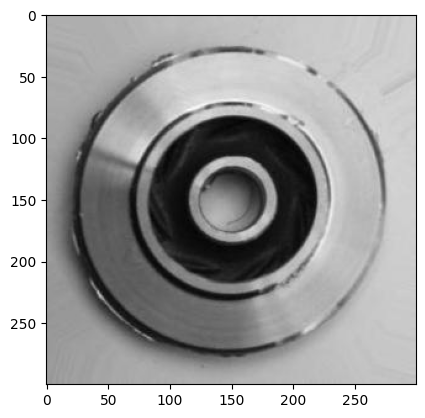

1/1 [==============================] - 0s 20ms/step


In [ ]:
from keras.applications.vgg16 import preprocess_input

from PIL import Image
# Load the image from the file path

image_path = '/content/drive/MyDrive/Test_Images/cast_def_3.jpeg'
img = Image.open(image_path)

# Display the original image

plt.imshow(img)
plt.show()

# Preprocess the image for vgg model

img_resized = cv2.resize(np.array(img), (224, 224))
img_resized = preprocess_input(img_resized)
img_resized = img_resized/255

# Extract image features using vgg
input_img_feature = vgg_model.predict(np.expand_dims(img_resized, axis=0))
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)

# Make predictions using the svc model
img_prediction = svc_model.predict(input_img_features)[0]


In [ ]:
# classify the possible class of the image
def classifyImage(img_prediction):
  if img_prediction > 0.5:
      print('Washer Image is NOT DEFECTIVE(Ok_front)')
  else:
      print('Washer Image is DEFECTIVE(def_front)')

classifyImage(img_prediction)


Washer Image is DEFECTIVE(def_front)


**Okay Image - NOT DEFECTIVE**

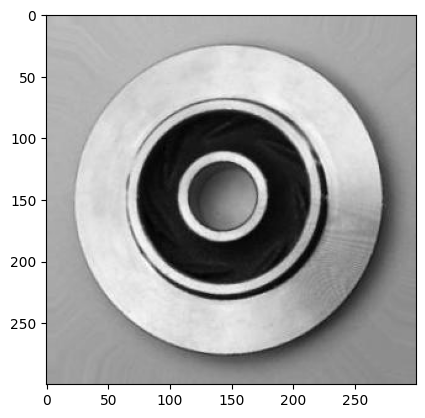

1/1 [==============================] - 0s 30ms/step


In [ ]:
from keras.applications.vgg16 import preprocess_input

from PIL import Image
# Load the image from the file path

image_path = '/content/drive/MyDrive/Test_Images/cast_ok_2.jpeg'
img = Image.open(image_path)

# Display the original image

plt.imshow(img)
plt.show()

# Preprocess the image for vgg model

img_resized = cv2.resize(np.array(img), (224, 224))
img_resized = preprocess_input(img_resized)
img_resized = img_resized/255

# Extract image features using vgg model
input_img_feature = vgg_model.predict(np.expand_dims(img_resized, axis=0))
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)

# Make predictions using the svc model
img_prediction1 = svc_model.predict(input_img_features)[0]


In [ ]:
# Call Function

classifyImage(img_prediction1)


Washer Image is NOT DEFECTIVE(Ok_front)


**Download Model**

In [ ]:
##
import joblib

file_name = '/content/drive/MyDrive/MLClassData/vgg_svc_model.joblib'

# Save the SVM model using joblib
joblib.dump(svc_model, file_name)

print(f"SVC(SVM) model saved at: {file_name}")

SVC(SVM) model saved at: /content/drive/MyDrive/MLClassData/vgg_svc_model.joblib
